In [3]:
#general package
import json
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from dateutil.parser import parse
from itertools import combinations
 
#statistical package
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats

#pre-process: encoding, pca, clustering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

#modelling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from itertools import chain, combinations
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

import random
import tensorflow as tf 

In [4]:
df_bat = pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_encode_python.csv')
df_bat

,Result,match_number,team_code,opponent_code,gender,season,team_score,team_wickets,winner_code,toss_winner_code,home_advantage,venue_city_code,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,1,5,4,1,0,2021,132,7,4,1,0,1,0,139.000000,1.000000,5.000000,1
1,1,6,0,2,0,2021,113,9,0,0,0,2,1,128.000000,0.000000,6.000000,0
2,1,7,3,6,0,2021,149,7,3,3,0,6,1,131.000000,1.000000,4.000000,1
3,0,8,7,5,0,2021,110,7,5,5,1,5,0,130.000000,0.000000,8.000000,0
4,1,10,6,1,0,2021,151,4,6,6,0,1,1,116.000000,0.000000,7.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,30,1,0,1,2022,139,6,0,0,1,0,0,140.642857,0.428571,6.571429,0
111,1,31,3,5,1,2022,135,8,3,5,1,5,0,152.714286,0.428571,6.000000,1
112,0,32,4,2,1,2022,143,9,2,4,0,2,1,145.500000,0.571429,5.785714,1
113,0,40,1,2,1,2022,150,7,2,1,0,2,1,140.533333,0.400000,6.533333,0


In [5]:
X = df_bat.drop("Result", axis=1)
y = df_bat['Result']

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [7]:
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

### KNN (K-Nearest Neighbors)

In [46]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the optimal parameters for KNN
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_gscv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
knn_gscv.fit(X_scaled, y)

print("Best parameters for KNN:", knn_gscv.best_params_)

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}


In [10]:
#Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'distance'}
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=14, weights='distance')
y_prob_knn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    knn.fit(X_train, y_train)
    y_prob_knn[test_idx] = knn.predict_proba(X_test)[:, 1]

y_pred_knn = (y_prob_knn > 0.5).astype(int)

print("Predicted Probabilities for KNN:")
print(y_prob_knn)

Predicted Probabilities for KNN:
[0.50006789 0.35970937 0.49796351 0.33400706 0.4468195  0.3443469
 0.19971974 0.4296918  0.59052523 0.26362383 0.35087612 0.57187193
 0.15061631 0.66079048 0.35595202 0.35616542 0.32595235 0.55580652
 0.93488805 0.597309   0.3212195  0.22468683 0.42403797 0.65490484
 0.42795204 0.26659899 0.32386036 0.28763169 0.34425825 0.20162194
 0.34337719 0.43149112 0.26461308 0.43472121 0.34830427 0.40652928
 0.50592232 0.26474958 0.63808044 0.61729672 0.44424999 0.26805775
 0.47132774 0.86757359 0.55514308 0.27199799 0.43954078 0.72526498
 0.48830946 0.13002991 0.27462981 0.41102579 0.33076737 0.21536071
 0.49647108 0.50556414 0.48245436 0.44383703 0.66170531 0.40544072
 0.57225784 0.41340904 0.64303165 0.36342906 0.66167028 0.64833634
 0.53235607 0.63284969 0.42661356 0.41043523 0.36441005 0.22324835
 0.40869924 0.25781379 0.36739    0.22922163 0.29616228 0.56796188
 0.54695362 0.60413292 0.28571009 0.20052315 0.62560953 0.64185618
 0.41284379 0.53850396 0.50142

In [11]:
y_pred_knn

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0])

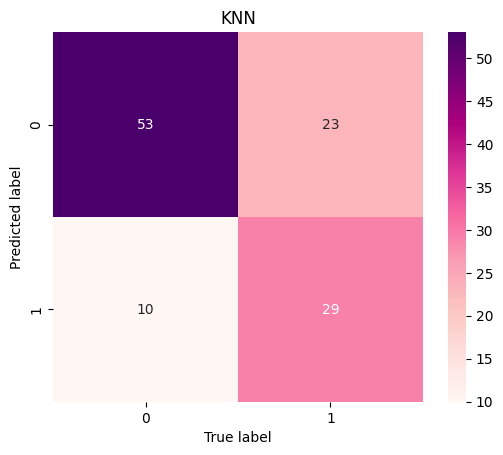

Accuracy:	0.713043
F1-score:	0.699976
Precision:	0.720479
Recall:		0.699481

Classification performance:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76        63
           1       0.74      0.56      0.64        52

    accuracy                           0.71       115
   macro avg       0.72      0.70      0.70       115
weighted avg       0.72      0.71      0.71       115



In [12]:
# Evaluation for KNN
mat_knn = confusion_matrix(y, y_pred_knn)
sns.heatmap(mat_knn.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_knn))
print("F1-score:\t%f" % f1_score(y, y_pred_knn, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_knn, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_knn, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_knn))

### SVM (Support Vector Machine) 

In [13]:
#Finding the optimal parameters for SVM
svm = SVC(probability=True)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}

svm_gscv = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
svm_gscv.fit(X_scaled, y)

print("Best parameters for SVM:", svm_gscv.best_params_)

Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [8]:
#Best parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
svm = SVC(C=10, gamma='scale', kernel='rbf', probability=True)
y_prob_svm = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    svm.fit(X_train, y_train)
    y_prob_svm[test_idx] = svm.predict_proba(X_test)[:, 1]

y_pred_svm = (y_prob_svm > 0.5).astype(int)
print("\nPredicted Probabilities for SVM:")
print(y_prob_svm)


Predicted Probabilities for SVM:
[0.63613954 0.53890661 0.48262542 0.19703642 0.80470751 0.26654438
 0.16996816 0.34242939 0.89780854 0.09891206 0.49252742 0.21297193
 0.16678129 0.87402245 0.69977211 0.46574001 0.26113967 0.42558665
 0.96733354 0.50545152 0.12742878 0.18279759 0.12934553 0.79418951
 0.4677328  0.09515214 0.22326509 0.48503375 0.31764033 0.26443713
 0.48599835 0.69113077 0.06912418 0.64541673 0.12966585 0.04523458
 0.59549524 0.13429177 0.85177753 0.82598934 0.71849953 0.05312271
 0.29447469 0.99998092 0.35041456 0.11985589 0.4170576  0.98982835
 0.53947596 0.01039041 0.20382949 0.5        0.25281086 0.08524407
 0.68716525 0.56571271 0.30078552 0.51116624 0.90416165 0.39884627
 0.47382037 0.39896131 0.72409435 0.3011583  0.93592247 0.7805623
 0.95703168 0.4915019  0.60287855 0.31966117 0.37071334 0.06584198
 0.18540959 0.1533607  0.50945202 0.35327488 0.15946585 0.74465784
 0.21931829 0.88940403 0.32806717 0.13416586 0.54234829 0.5
 0.27075531 0.22284234 0.71861524 0.

In [10]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(svm, X, y, scoring='roc_auc', n_repeats=30)

# Get importance
importance = results.importances_mean
importance


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [15]:
y_pred_svm

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0])

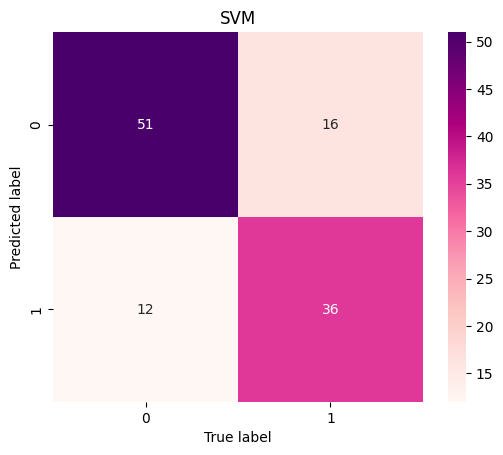

Accuracy:	0.756522
F1-score:	0.752308
Precision:	0.755597
Recall:		0.750916

Classification performance:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78        63
           1       0.75      0.69      0.72        52

    accuracy                           0.76       115
   macro avg       0.76      0.75      0.75       115
weighted avg       0.76      0.76      0.76       115



In [16]:
mat_svm = confusion_matrix(y, y_pred_svm)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_svm))
print("F1-score:\t%f" % f1_score(y, y_pred_svm, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_svm, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_svm))

### Deep Netural Networks

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [18]:
def create_model(dropout_rate=0.0, activation='relu'):
    model = Sequential()
    model.add(Dense(16, input_dim=16, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 30, 40],
    'epochs': [10, 50, 100],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'activation': ['relu', 'tanh']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_scaled, y)

print("Best parameters found: ", grid_result.best_params_)
print('Best score', grid_result.best_score_)

2023-09-28 03:44:11.336261: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.670463: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.707701: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.753241: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.777655: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.801087: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:11.969217: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:44:12.034725: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-28 03:47:32.791058: W tensorflow

Best parameters found:  {'activation': 'relu', 'batch_size': 10, 'dropout_rate': 0.0, 'epochs': 100}
Best score 0.7659091025590896


In [20]:
#Best parameters found:  {'activation': 'relu', 'batch_size': 20, 'dropout_rate': 0.2, 'epochs': 100}
#Best score 0.7583333373069763

# Define the model with the optimal parameters
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_prob_dnn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = create_model()
    model.fit(X_train, y_train, epochs=100, batch_size=20, verbose=0)
    y_prob_dnn[test_idx] = model.predict(X_test).flatten()

y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

print("DNN Model")
print("Predicted Probabilities:")
print(y_prob_dnn) 

1/1 [==============================] - 0s 25ms/step
DNN Model
Predicted Probabilities:
[0.56584328 0.06337019 0.5389176  0.1094339  0.4440971  0.08222742
 0.17463611 0.07757544 0.34151483 0.04817831 0.40241545 0.58006448
 0.18310352 0.5287692  0.29104257 0.10853103 0.08880706 0.43470055
 0.99171263 0.70638925 0.20850638 0.10120144 0.1446202  0.90154171
 0.58216578 0.11357391 0.09047937 0.58235872 0.0011819  0.01767899
 0.59016496 0.53827399 0.08642319 0.39106852 0.02020363 0.3354114
 0.31997576 0.08400573 0.77965575 0.71439451 0.30143183 0.1468745
 0.25732031 0.97832197 0.47709113 0.18731947 0.78535479 0.90962774
 0.07681812 0.0176778  0.13300641 0.24346267 0.20418444 0.00519477
 0.74548548 0.65696239 0.58988756 0.32068175 0.4824093  0.51313639
 0.54400933 0.03918476 0.88804388 0.37750053 0.73373055 0.785348
 0.81334382 0.93714613 0.38515964 0.15551846 0.45003712 0.14701335
 0.14232711 0.08341131 0.47625583 0.06881611 0.0891303  0.93264568
 0.77282113 0.856525   0.35494816 0.11935738 0

In [21]:
y_pred_dnn

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0])

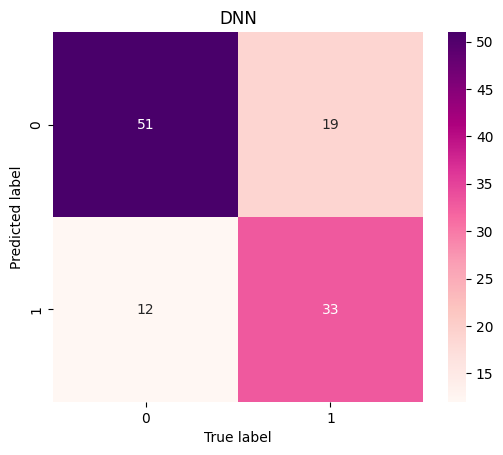

Accuracy:	0.730435
F1-score:	0.680412
Precision:	0.733333
Recall:		0.634615

Classification performance:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        63
           1       0.73      0.63      0.68        52

    accuracy                           0.73       115
   macro avg       0.73      0.72      0.72       115
weighted avg       0.73      0.73      0.73       115



In [22]:
mat_dnn = confusion_matrix(y, y_pred_dnn)
sns.heatmap(mat_dnn.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("DNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_dnn))
print("F1-score:\t%f" % f1_score(y, y_pred_dnn))
print("Precision:\t%f" % precision_score(y, y_pred_dnn))
print("Recall:\t\t%f" % recall_score(y, y_pred_dnn))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_dnn))

### Integrated Models

### XGBoost（Extreme Gradient Boosting）

In [23]:
import xgboost as xgb

In [24]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters for XGBoost: ", grid_search.best_params_)

Best parameters for XGBoost:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}


In [25]:
#Best parameters for XGBoost:  {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.9}

xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.9, 
    learning_rate=0.05, 
    max_depth=3, 
    n_estimators=500, 
    subsample=0.9,
    use_label_encoder=False
)

y_prob_xgb = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train, y_train)
    y_prob_xgb[test_idx] = xgb_model.predict_proba(X_test)[:, 1]

y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

print("\nPredicted Probabilities for XGBoost:")
print(y_prob_xgb)


Predicted Probabilities for XGBoost:
[0.90284252 0.06105065 0.62589878 0.24996728 0.53507572 0.0204287
 0.69600469 0.02793084 0.78692597 0.03833386 0.51017368 0.04541099
 0.04954966 0.68447655 0.47666901 0.24985845 0.01097915 0.77545494
 0.9853099  0.44605973 0.06487225 0.00187714 0.74832755 0.82215142
 0.87730801 0.04015838 0.02186188 0.27220595 0.03640138 0.09065785
 0.86794591 0.26697421 0.03710154 0.9336158  0.07283462 0.50676602
 0.46071082 0.10844097 0.81024718 0.83983517 0.11817804 0.11518297
 0.35559937 0.99588287 0.01215424 0.27041698 0.9817934  0.98721969
 0.06092323 0.00135083 0.0073824  0.10174838 0.75516468 0.02487429
 0.75931168 0.93899262 0.67218411 0.50907731 0.49784207 0.90413481
 0.59824383 0.05056096 0.69818842 0.06970716 0.57104236 0.48632386
 0.27001613 0.92020971 0.80192596 0.06719833 0.18347584 0.00509151
 0.05835568 0.0617951  0.81744194 0.06969278 0.01729167 0.77058494
 0.59868985 0.93062651 0.70523834 0.12341835 0.50856274 0.83904588
 0.06312583 0.60998189 0.

In [26]:
y_pred_xgb

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0])

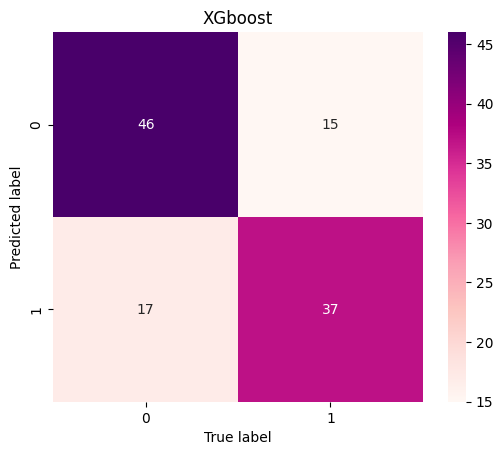

Accuracy:	0.721739
F1-score:	0.698113
Precision:	0.685185
Recall:		0.711538

Classification performance:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        63
           1       0.69      0.71      0.70        52

    accuracy                           0.72       115
   macro avg       0.72      0.72      0.72       115
weighted avg       0.72      0.72      0.72       115



In [27]:
mat_xgb = confusion_matrix(y, y_pred_xgb)
sns.heatmap(mat_xgb.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("XGboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_xgb))
print("F1-score:\t%f" % f1_score(y, y_pred_xgb))
print("Precision:\t%f" % precision_score(y, y_pred_xgb))
print("Recall:\t\t%f" % recall_score(y, y_pred_xgb))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_xgb))

### CatBoost 

CatBoost's main advantage: It uses a special algorithm to encode classification features that often works better than traditional One-Hot Encoding or Label Encoding. Because it is not necessary to use the encoded dataset for training catboost, the original dataset can be used.

In [28]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb

In [30]:
df= pd.read_csv('/Users/quinne/Desktop/all_code/dissertation_dataset/halftime_dataframe_R.csv')
df

,Result,match_number,team,opponent,gender,season,team_score,team_wickets,winner,toss_winner,home_advantage,venue_city,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,win,5,Oval Invincibles,London Spirit,female,2021,132,7,Oval Invincibles,London Spirit,no,"Lord's, London London",no,139.000000,1.000000,5.000000,win
1,win,6,Birmingham Phoenix,Manchester Originals,female,2021,113,9,Birmingham Phoenix,Birmingham Phoenix,no,"Old Trafford, Manchester Manchester",yes,128.000000,0.000000,6.000000,lose
2,win,7,Northern Superchargers,Trent Rockets,female,2021,149,7,Northern Superchargers,Northern Superchargers,no,"Trent Bridge, Nottingham Nottingham",yes,131.000000,1.000000,4.000000,win
3,lose,8,Welsh Fire,Southern Brave,female,2021,110,7,Southern Brave,Southern Brave,yes,"Sophia Gardens, Cardiff Cardiff",no,130.000000,0.000000,8.000000,lose
4,win,10,Trent Rockets,London Spirit,female,2021,151,4,Trent Rockets,Trent Rockets,no,"Lord's, London London",yes,116.000000,0.000000,7.000000,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,lose,30,London Spirit,Birmingham Phoenix,male,2022,139,6,Birmingham Phoenix,Birmingham Phoenix,yes,"Lord's, London London",no,140.642857,0.428571,6.571429,lose
111,win,31,Northern Superchargers,Southern Brave,male,2022,135,8,Northern Superchargers,Southern Brave,yes,"Headingley, Leeds Leeds",no,152.714286,0.428571,6.000000,win
112,lose,32,Oval Invincibles,Manchester Originals,male,2022,143,9,Manchester Originals,Oval Invincibles,no,"Old Trafford, Manchester Manchester",yes,145.500000,0.571429,5.785714,win
113,lose,40,London Spirit,Manchester Originals,male,2022,150,7,Manchester Originals,London Spirit,no,"The Rose Bowl, Southampton Southampton",yes,140.533333,0.400000,6.533333,lose


In [31]:
# Transforming the 'Result' column to binary format
df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)

In [32]:
# Splitting the data into X (features) and y (target)
X = df.drop(columns=['Result'])
y = df['Result']

# List of categorical features
cat_features = [
    'team', 'opponent', 'gender', 'home_advantage', 'venue_city', 
    'toss_winner', 'winner', 'choose_to_bat', 'last_match_result'
]

In [33]:
# Initialize a base model
model = CatBoostClassifier(cat_features=cat_features, verbose=0)

# Parameter grid
grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

# Grid search
grid_search_result = model.grid_search(grid, 
                                       X=Pool(X, label=y, cat_features=cat_features), 
                                       cv=10,  
                                       plot=False)

# Best parameters from grid search
best_params = grid_search_result['params']



bestTest = 0.6460298114
bestIteration = 83

0:	loss: 0.6460298	best: 0.6460298 (0)	total: 201ms	remaining: 16.1s

bestTest = 0.6380247496
bestIteration = 8

1:	loss: 0.6380247	best: 0.6380247 (1)	total: 310ms	remaining: 12.3s

bestTest = 0.632254591
bestIteration = 8

2:	loss: 0.6322546	best: 0.6322546 (2)	total: 412ms	remaining: 10.7s

bestTest = 0.6411599294
bestIteration = 84

3:	loss: 0.6411599	best: 0.6322546 (2)	total: 543ms	remaining: 10.5s

bestTest = 0.6310070031
bestIteration = 47

4:	loss: 0.6310070	best: 0.6310070 (4)	total: 666ms	remaining: 10.1s

bestTest = 0.626970699
bestIteration = 8

5:	loss: 0.6269707	best: 0.6269707 (5)	total: 789ms	remaining: 9.86s

bestTest = 0.6485946045
bestIteration = 95

6:	loss: 0.6485946	best: 0.6269707 (5)	total: 912ms	remaining: 9.64s

bestTest = 0.6406715345
bestIteration = 19

7:	loss: 0.6406715	best: 0.6269707 (5)	total: 1s	remaining: 9.18s

bestTest = 0.62043951
bestIteration = 51

8:	loss: 0.6204395	best: 0.6204395 (8)	total: 1.11s	r

In [34]:
print("Best parameters for CatBoost: ", best_params)

Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.1}


In [35]:
#Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.1}

# Initialize the CatBoost model with the best parameters
model = CatBoostClassifier(
    depth=5, 
    l2_leaf_reg=1, 
    iterations=1000, 
    learning_rate=0.1,
    cat_features=cat_features,
    verbose=0  
)

# Train the model on the entire dataset
model.fit(X, y)

In [36]:
# Train# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)
y_prob_catboost = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_prob_catboost[test_idx] = model.predict_proba(X_test)[:, 1]

y_pred_catboost = (y_prob_catboost > 0.5).astype(int)

print("\nPredicted Probabilities for CatBoost:")
print(y_prob_catboost)


Predicted Probabilities for CatBoost:
[9.99928228e-01 9.98636803e-01 9.98931602e-01 2.43345850e-03
 9.96666095e-01 8.60029723e-05 7.06914929e-03 9.99241288e-01
 9.97146111e-01 7.19840680e-05 9.28130871e-01 8.76129478e-04
 8.00160672e-05 2.43208597e-04 1.02009900e-04 1.73956136e-04
 5.85969306e-05 1.15487256e-04 9.98030425e-01 2.42827144e-04
 3.06570046e-05 8.30312437e-05 1.35642474e-04 9.99562183e-01
 9.99864795e-01 3.22186649e-04 9.99432233e-01 9.99748041e-01
 2.62035812e-04 1.15647023e-04 9.99012082e-01 9.97646012e-01
 2.82539827e-04 6.18235374e-04 3.60519315e-04 1.48863420e-04
 9.99726248e-01 6.61077770e-05 9.99714392e-01 3.58078564e-04
 1.76101112e-04 4.48624825e-05 9.99651888e-01 9.99841267e-01
 9.90689347e-01 6.65372078e-05 9.99315922e-01 9.99834358e-01
 2.90097488e-04 7.80944008e-05 1.09741140e-04 5.15325804e-05
 6.74345200e-01 1.04224483e-04 9.99896563e-01 1.16566230e-04
 3.76160558e-04 9.99758569e-01 9.99712680e-01 9.99766432e-01
 9.99759000e-01 7.20744432e-05 9.99501766e-01 

In [37]:
y_pred_catboost

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0])

In [38]:
feature_importances = model.get_feature_importance()
feature_names = X.columns.tolist()
features = sorted(zip(feature_importances, feature_names), reverse=True)
for importance, name in features:
    print(f"{name}: {importance}")

winner: 41.01509036414516
team: 28.4267678403038
choose_to_bat: 6.509713113622371
toss_winner: 6.331037231332671
home_advantage: 5.219796985803582
venue_city: 3.398829482467708
team_score: 2.101497871134854
opponent: 1.9869171717444742
match_number: 1.428934128751915
team_wickets: 1.2504914692585212
avg_score: 0.9918433701917808
avg_wickets_out: 0.5076562910609862
avg_win_rate: 0.488397093954545
last_match_result: 0.1683208695606284
gender: 0.10845564811150987
season: 0.06625106855554079


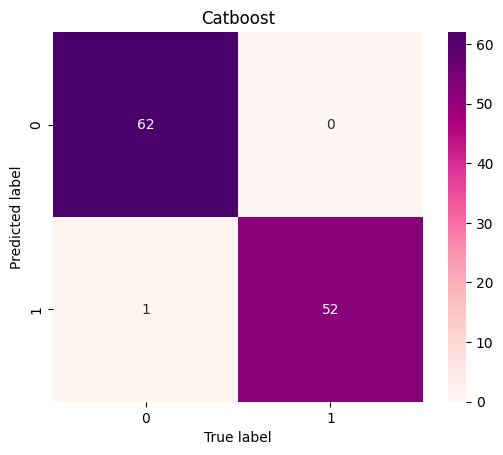

Accuracy:	0.991304
F1-score:	0.990476
Precision:	0.981132
Recall:		1.000000

Classification performance:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.98      1.00      0.99        52

    accuracy                           0.99       115
   macro avg       0.99      0.99      0.99       115
weighted avg       0.99      0.99      0.99       115



In [39]:
mat_catboost = confusion_matrix(y, y_pred_catboost)  
sns.heatmap(mat_catboost.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Catboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_catboost))  
print("F1-score:\t%f" % f1_score(y, y_pred_catboost))  
print("Precision:\t%f" % precision_score(y, y_pred_catboost))  
print("Recall:\t\t%f" % recall_score(y, y_pred_catboost))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_catboost))  